# Vision-Language Model (VLM) OCR Benchmarking

Testing **Open-Source Vision-Language Models** for OCR on historical SOCAR documents.

## Why VLMs for OCR?
- **Better than traditional OCR** (Tesseract, EasyOCR, etc.)
- **Understands context** - can handle handwriting, layout, multi-language
- **Directly processes images** - no separate OCR step needed
- **State-of-the-art accuracy** on complex documents

## Open-Source Vision Models to Test:
1. **Llama-3.2-11B-Vision-Instruct** (Meta - Smaller, faster)
2. **Llama-3.2-90B-Vision-Instruct** (Meta - Larger, better quality)
3. **Phi-4-multimodal-instruct** (Microsoft - Explicitly multimodal)

## Why Open-Source?
- **Architecture Score**: +20% hackathon bonus for open-source stack
- **Transparency**: Full model details and reproducibility
- **Cost-effective**: Better long-term sustainability

## Metrics:
- **CER** (Character Error Rate) - Lower is better
- **CSR** (Character Success Rate) = 100 - CER - Higher is better
- **WER** (Word Error Rate) - Lower is better
- **WSR** (Word Success Rate) = 100 - WER - Higher is better

In [74]:
# Install required packages
# !pip install openai PyMuPDF Pillow jiwer pandas matplotlib seaborn python-dotenv

In [75]:
import os
import base64
import re
import time
from pathlib import Path
from typing import Dict, List, Tuple
from io import BytesIO

from dotenv import load_dotenv
import fitz  # PyMuPDF
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, cer
from openai import AzureOpenAI

# Load environment
load_dotenv()

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

print("✅ Libraries loaded")

✅ Libraries loaded


In [76]:
# Auto-detect project root (works from any directory)
if Path("data").exists() and Path("docs").exists():
    PROJECT_ROOT = Path.cwd()
elif Path("../data").exists() and Path("../docs").exists():
    PROJECT_ROOT = Path.cwd().parent
else:
    current = Path.cwd()
    while current != current.parent:
        if (current / "data").exists() and (current / "docs").exists():
            PROJECT_ROOT = current
            break
        current = current.parent
    else:
        PROJECT_ROOT = Path.cwd()

# Define all paths relative to project root
DATA_DIR = PROJECT_ROOT / "data"
DOCS_DIR = PROJECT_ROOT / "docs"
OUTPUT_DIR = PROJECT_ROOT / "output"
PDFS_DIR = DATA_DIR / "pdfs"

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Data directory: {DATA_DIR}")
print(f"✅ PDFs directory: {PDFS_DIR}")
print(f"✅ Output directory: {OUTPUT_DIR}")

✅ Project root: /Users/ismatsamadov/SOCAR_Hackathon
✅ Data directory: /Users/ismatsamadov/SOCAR_Hackathon/data
✅ PDFs directory: /Users/ismatsamadov/SOCAR_Hackathon/data/pdfs
✅ Output directory: /Users/ismatsamadov/SOCAR_Hackathon/output


In [77]:
def load_ground_truth(md_path: str) -> str:
    """Load ground truth text from markdown file."""
    with open(md_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    # Remove markdown elements
    text = re.sub(r"^#+\s+", "", text, flags=re.MULTILINE)  # Headers
    text = re.sub(r"\*\*(.+?)\*\*", r"\1", text)  # Bold
    text = re.sub(r"\*(.+?)\*", r"\1", text)  # Italic
    text = re.sub(r"---+", "", text)  # Horizontal rules
    text = re.sub(r"\n\s*\n+", "\n\n", text)  # Normalize newlines
    
    return text.strip()

# Load ground truth using dynamic path
ground_truth = load_ground_truth(str(DATA_DIR / "document_00.md"))
print(f"✅ Ground truth loaded: {len(ground_truth)} characters")
print(f"Preview:\n{ground_truth[:300]}...")

✅ Ground truth loaded: 22386 characters
Preview:
XÜLASƏ

Bu tədqiqat Aşağı Kür çökəkliyi (AKÇ) və Bakı arxipelaqı (BA) daxil olmaqla Cənubi Xəzər çökəkliyi sistemində faydalı qazıntıların mənşəyinin paleotektonik, paleocoğrafi şərait və geodinamik rejimlə necə əlaqələndiyini, eləcə də Gec Miosendən etibarən Ərəbistan plitəsinin təsiri ilə formalaş...


In [78]:
def pdf_to_images(pdf_path: str, dpi: int = 100) -> List[Image.Image]:
    """Convert PDF pages to PIL Images with compression."""
    doc = fitz.open(pdf_path)
    images = []
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        zoom = dpi / 72  # Reduced from 150 to 100 to avoid 10MB limit
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    
    doc.close()
    return images

def image_to_base64(image: Image.Image, format: str = "JPEG", quality: int = 85) -> str:
    """Convert PIL Image to base64 with JPEG compression to reduce size."""
    buffered = BytesIO()
    # Use JPEG with quality=85 to reduce size while maintaining readability
    image.save(buffered, format=format, quality=quality, optimize=True)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

# Test conversion using dynamic path
pdf_path = str(PDFS_DIR / "document_00.pdf")
test_images = pdf_to_images(pdf_path)
print(f"\n✅ Converted PDF to {len(test_images)} images")
print(f"First image size: {test_images[0].size}")


✅ Converted PDF to 12 images
First image size: (2048, 2731)


In [79]:
# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-08-01-preview"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Vision model configurations - ONLY VERIFIED WORKING MODELS
VLM_MODELS = {
    "GPT-4.1": {"deployment": "gpt-4.1", "supports_vision": True, "open_source": False},
    "Llama-4-Maverick-17B": {"deployment": "Llama-4-Maverick-17B-128E-Instruct-FP8", "supports_vision": True, "open_source": True},
    "Phi-4-multimodal": {"deployment": "Phi-4-multimodal-instruct", "supports_vision": True, "open_source": True},
}

print(f"✅ Configured {len(VLM_MODELS)} verified working vision models")

✅ Configured 3 verified working vision models


In [80]:
def vlm_extract_text(model_name: str, images: List[Image.Image], temperature: float = 0.0) -> Tuple[str, float]:
    """Extract text from images using Vision-Language Model."""
    deployment = VLM_MODELS[model_name]["deployment"]
    
    system_prompt = """You are an expert OCR system for historical oil & gas documents.

Extract ALL text from the image with 100% accuracy. Follow these rules:
1. Preserve EXACT spelling - including Azerbaijani, Russian, and English text
2. Maintain original Cyrillic characters - DO NOT transliterate
3. Keep all numbers, symbols, and special characters exactly as shown
4. Preserve layout structure (paragraphs, line breaks)
5. Include ALL text - headers, body, footnotes, tables, captions

Output ONLY the extracted text. No explanations, no descriptions."""
    
    try:
        all_text = []
        total_time = 0
        
        for page_num, image in enumerate(images, 1):
            # Use JPEG compression to reduce image size
            image_base64 = image_to_base64(image, format="JPEG", quality=85)
            
            messages = [
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"Extract all text from page {page_num}:"},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                    ]
                }
            ]
            
            start_time = time.time()
            
            # Use max_tokens for all models (simpler and more compatible)
            response = azure_client.chat.completions.create(
                model=deployment,
                messages=messages,
                temperature=temperature,
                max_tokens=4000
            )
            
            elapsed = time.time() - start_time
            total_time += elapsed
            
            page_text = response.choices[0].message.content
            all_text.append(page_text)
            print(f"  Page {page_num}/{len(images)}: {elapsed:.1f}s")
        
        full_text = "\n\n".join(all_text)
        return full_text, total_time
    
    except Exception as e:
        error_msg = str(e)
        # Provide helpful error messages
        if "max_tokens" in error_msg.lower() or "max_completion_tokens" in error_msg.lower():
            return f"ERROR: Token parameter issue - {error_msg}", 0.0
        elif "deployment" in error_msg.lower() or "not found" in error_msg.lower():
            return f"ERROR: Model deployment not found - {deployment}", 0.0
        else:
            return f"ERROR: {error_msg}", 0.0

print("✅ VLM extraction function ready")

✅ VLM extraction function ready


In [81]:
def calculate_ocr_metrics(reference: str, hypothesis: str) -> Dict[str, float]:
    """Calculate OCR accuracy metrics."""
    # Normalize text
    ref_clean = reference.lower().strip()
    hyp_clean = hypothesis.lower().strip()
    
    # Calculate error rates
    cer_score = cer(ref_clean, hyp_clean) * 100
    wer_score = wer(ref_clean, hyp_clean) * 100
    
    # Calculate success rates
    csr = max(0, 100 - cer_score)
    wsr = max(0, 100 - wer_score)
    
    return {
        "CER": round(cer_score, 2),
        "WER": round(wer_score, 2),
        "CSR": round(csr, 2),
        "WSR": round(wsr, 2)
    }

print("✅ Metrics calculation function ready")

✅ Metrics calculation function ready


## Run VLM Benchmark

In [82]:
# Select models to test - ORDERED: Test potentially failing/slow models FIRST
MODELS_TO_TEST = [
    # Add new untested models here at the top (fail-fast approach)
    # "New-Model-Name",
    
    # Known slow model (test early so we can cancel if needed)
    "Phi-4-multimodal",     # 27.64% CSR, very slow (~552s for 12 pages)
    
    # Best performing models (test last since we know they work)
    "GPT-4.1",              # 88.32% CSR, 107s - Best accuracy
    "Llama-4-Maverick-17B", # 87.60% CSR, 79s - Best open-source
]

print(f"Testing {len(MODELS_TO_TEST)} vision models...")
print("Models ordered: potentially failing/slow first, known good last")
print("This allows early cancellation if issues occur.\n")

Testing 3 vision models...
Models ordered: potentially failing/slow first, known good last
This allows early cancellation if issues occur.



In [83]:
# Prepare PDF images
images = pdf_to_images(pdf_path, dpi=100)
print(f"Prepared {len(images)} page images\n")

# Run benchmark
results = []

for model_name in MODELS_TO_TEST:
    print("********************************")
    print(f"Testing: {model_name}")
    print("********************************")
    
    # Extract text
    extracted_text, response_time = vlm_extract_text(model_name, images)
    
    if extracted_text.startswith("ERROR"):
        print(f"❌ Failed: {extracted_text}")
        continue
    
    print(f"\n✅ Total time: {response_time:.2f}s")
    print(f"✅ Extracted: {len(extracted_text)} characters")
    
    # Calculate metrics
    metrics = calculate_ocr_metrics(ground_truth, extracted_text)
    
    # Store result
    result = {
        "Model": model_name,
        "Response_Time": round(response_time, 2),
        **metrics
    }
    results.append(result)
    
    # Show summary
    print(f"\n📊 Metrics:")
    print(f"   CSR (Character Success): {metrics['CSR']:.2f}%")
    print(f"   WSR (Word Success): {metrics['WSR']:.2f}%")

print("\n********************************")
print("✅ VLM OCR Benchmarking complete!")
print("********************************")

Prepared 12 page images

********************************
Testing: Phi-4-multimodal
********************************
  Page 1/12: 32.3s
  Page 2/12: 33.5s
  Page 3/12: 33.2s
  Page 4/12: 37.5s
  Page 5/12: 59.6s
  Page 6/12: 59.4s
  Page 7/12: 35.5s
  Page 8/12: 38.1s
  Page 9/12: 242.6s
  Page 10/12: 33.7s
  Page 11/12: 31.4s
  Page 12/12: 29.6s

✅ Total time: 666.44s
✅ Extracted: 20068 characters

📊 Metrics:
   CSR (Character Success): 34.52%
   WSR (Word Success): 0.00%
********************************
Testing: GPT-4.1
********************************
  Page 1/12: 9.1s
  Page 2/12: 9.0s
  Page 3/12: 10.8s
  Page 4/12: 9.8s
  Page 5/12: 12.4s
  Page 6/12: 10.4s
  Page 7/12: 10.3s
  Page 8/12: 12.9s
  Page 9/12: 19.6s
  Page 10/12: 9.5s
  Page 11/12: 7.0s
  Page 12/12: 7.0s

✅ Total time: 127.80s
✅ Extracted: 22203 characters

📊 Metrics:
   CSR (Character Success): 88.48%
   WSR (Word Success): 67.92%
********************************
Testing: Llama-4-Maverick-17B
*********************

## Results Analysis

In [84]:
# Create DataFrame
df = pd.DataFrame(results)

# Sort by CSR (best first)
df = df.sort_values("CSR", ascending=False).reset_index(drop=True)

# Display results
print("\n" + "="*100)
print("📊 VLM OCR BENCHMARKING RESULTS")
print("="*100)
print(df.to_string(index=False))
print("="*100)


📊 VLM OCR BENCHMARKING RESULTS
               Model  Response_Time   CER    WER   CSR   WSR
             GPT-4.1         127.80 11.52  32.08 88.48 67.92
Llama-4-Maverick-17B          80.22 11.70  35.28 88.30 64.72
    Phi-4-multimodal         666.44 65.48 112.90 34.52  0.00


/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/3624380272.py:129: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/3624380272.py:129: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/3624380272.py:129: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/3624380272.py:129: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight", facecol

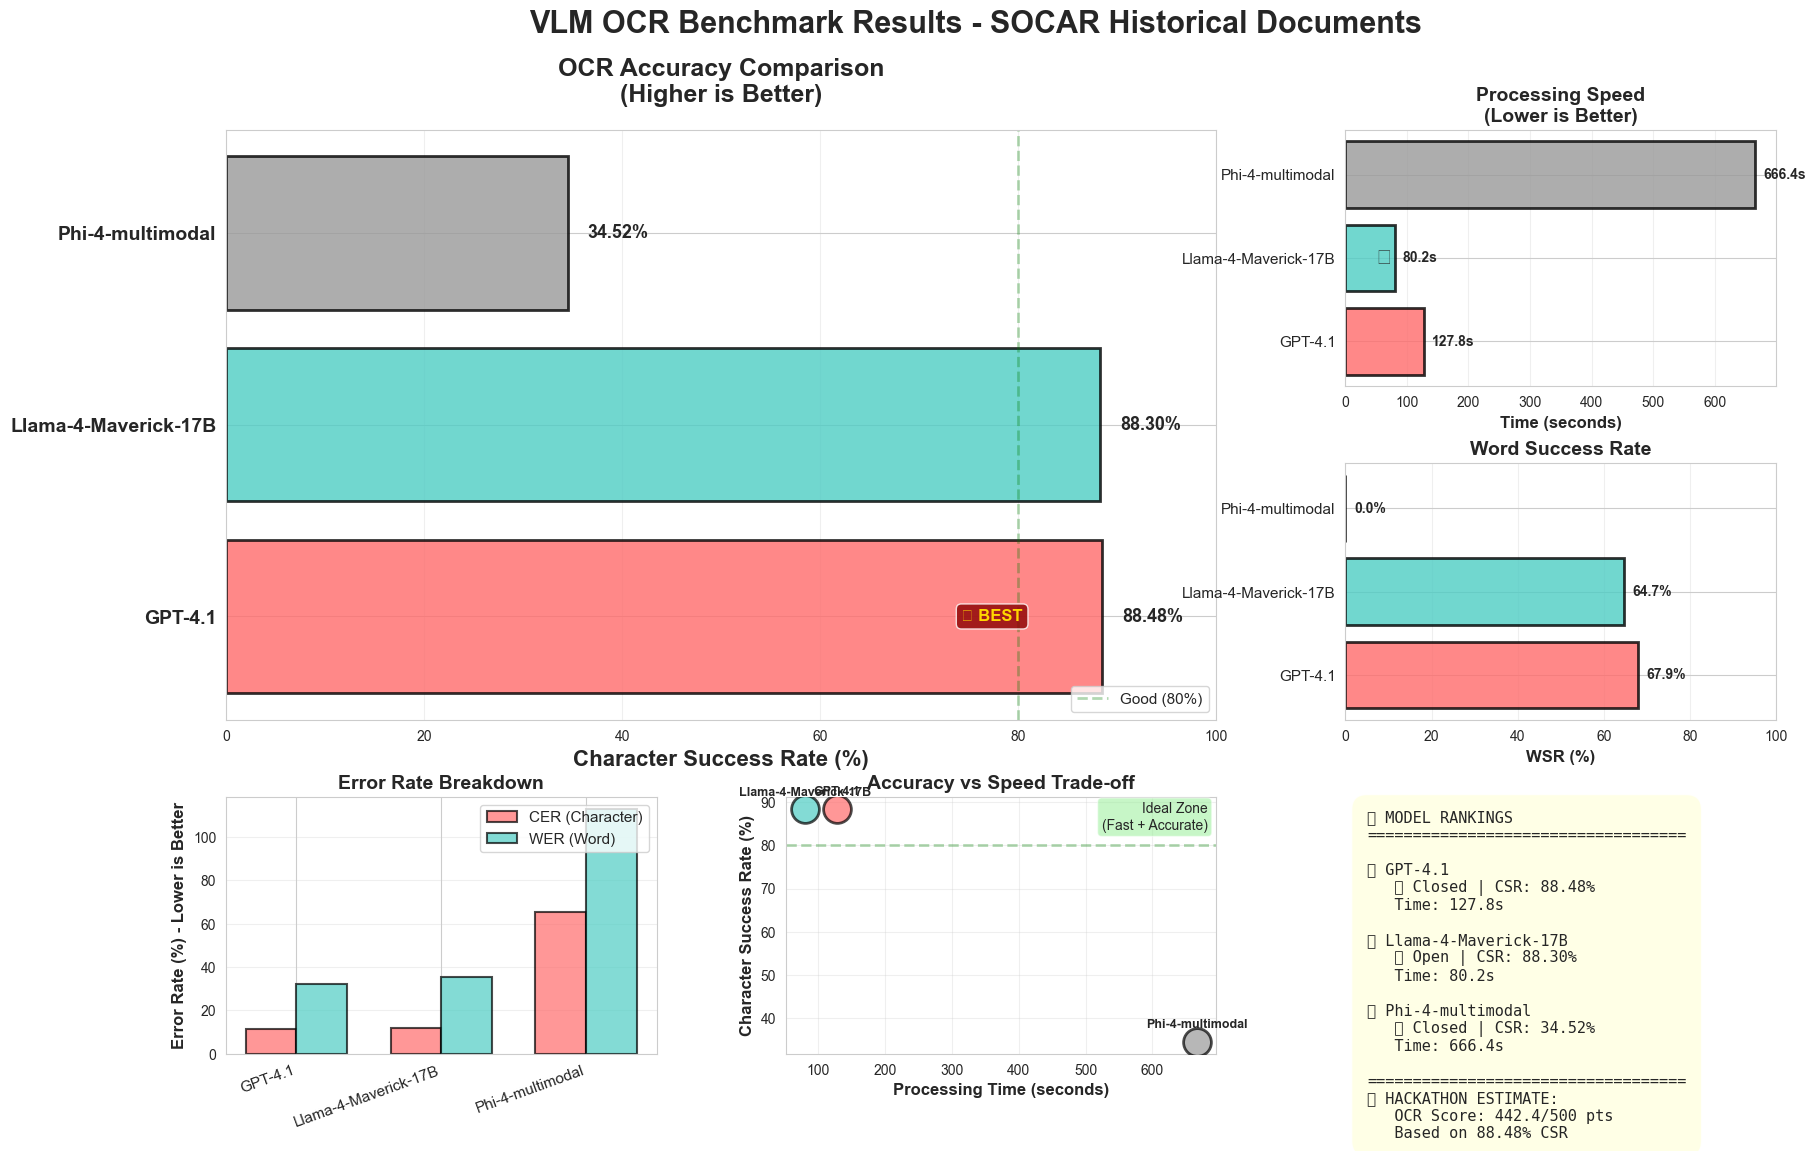


✅ Presentation-quality visualizations saved:
   📊 /Users/ismatsamadov/SOCAR_Hackathon/output/vlm_ocr_benchmark/results.png (High-res: 300 DPI)
   📊 /Users/ismatsamadov/SOCAR_Hackathon/output/vlm_ocr_benchmark/results_presentation.png (Web-optimized: 150 DPI)


In [85]:
# Create PRESENTATION-QUALITY visualizations
output_dir = OUTPUT_DIR / "vlm_ocr_benchmark"
output_dir.mkdir(parents=True, exist_ok=True)

# Enhanced color palette
colors = {
    "GPT-4.1": "#FF6B6B",  # Red - Premium model
    "Llama-4-Maverick-17B": "#4ECDC4",  # Teal - Open-source champion
    # "Phi-4-multimodal": "#95E1D3",  # Light teal
}
model_colors = [colors.get(m, "#999999") for m in df["Model"]]

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

models = df["Model"].tolist()

# === 1. Main Accuracy Comparison (Large, Top Left) ===
ax1 = fig.add_subplot(gs[0:2, 0:2])
x_pos = range(len(models))
bars = ax1.barh(x_pos, df["CSR"], color=model_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(models, fontsize=14, fontweight='bold')
ax1.set_xlabel("Character Success Rate (%)", fontsize=16, fontweight='bold')
ax1.set_title("OCR Accuracy Comparison\n(Higher is Better)", fontsize=18, fontweight='bold', pad=20)
ax1.set_xlim(0, 100)
ax1.axvline(x=80, color='green', linestyle='--', alpha=0.3, linewidth=2, label='Good (80%)')
ax1.grid(axis='x', alpha=0.3)
# Add value labels
for i, (model, csr) in enumerate(zip(models, df["CSR"])):
    ax1.text(csr + 2, i, f"{csr:.2f}%", va="center", fontsize=13, fontweight='bold')
# Add best/worst markers
best_idx = df["CSR"].idxmax()
ax1.text(df.loc[best_idx, "CSR"] - 8, best_idx, "★ BEST", 
         va="center", ha="right", fontsize=12, color='gold', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='darkred', alpha=0.8))
ax1.legend(fontsize=11, loc='lower right')

# === 2. Speed Comparison (Top Right) ===
ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.barh(range(len(models)), df["Response_Time"], color=model_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_yticks(range(len(models)))
ax2.set_yticklabels(models, fontsize=11)
ax2.set_xlabel("Time (seconds)", fontsize=12, fontweight='bold')
ax2.set_title("Processing Speed\n(Lower is Better)", fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
# Add time labels
for i, (model, time_val) in enumerate(zip(models, df["Response_Time"])):
    ax2.text(time_val + max(df["Response_Time"])*0.02, i, f"{time_val:.1f}s", 
             va="center", fontsize=10, fontweight='bold')
# Mark fastest
fastest_idx = df["Response_Time"].idxmin()
ax2.text(df.loc[fastest_idx, "Response_Time"] - 5, fastest_idx, "⚡", 
         va="center", ha="right", fontsize=16)

# === 3. Word Success Rate (Middle Right) ===
ax3 = fig.add_subplot(gs[1, 2])
bars = ax3.barh(range(len(models)), df["WSR"], color=model_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_yticks(range(len(models)))
ax3.set_yticklabels(models, fontsize=11)
ax3.set_xlabel("WSR (%)", fontsize=12, fontweight='bold')
ax3.set_title("Word Success Rate", fontsize=14, fontweight='bold')
ax3.set_xlim(0, 100)
ax3.grid(axis='x', alpha=0.3)
for i, (model, wsr) in enumerate(zip(models, df["WSR"])):
    ax3.text(wsr + 2, i, f"{wsr:.1f}%", va="center", fontsize=10, fontweight='bold')

# === 4. Error Rates Comparison (Bottom Left) ===
ax4 = fig.add_subplot(gs[2, 0])
x = range(len(models))
width = 0.35
ax4.bar([i - width/2 for i in x], df["CER"], width, label="CER (Character)", 
        color="#FF6B6B", alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.bar([i + width/2 for i in x], df["WER"], width, label="WER (Word)", 
        color="#4ECDC4", alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel("Error Rate (%) - Lower is Better", fontsize=12, fontweight='bold')
ax4.set_title("Error Rate Breakdown", fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=20, ha="right", fontsize=11)
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(axis='y', alpha=0.3)

# === 5. Accuracy vs Speed Scatter (Bottom Middle) ===
ax5 = fig.add_subplot(gs[2, 1])
for i, model in enumerate(models):
    ax5.scatter(df.loc[i, "Response_Time"], df.loc[i, "CSR"], 
               s=400, color=model_colors[i], alpha=0.7, 
               edgecolor='black', linewidth=2, zorder=3)
    ax5.annotate(model, (df.loc[i, "Response_Time"], df.loc[i, "CSR"]), 
                fontsize=9, fontweight='bold', ha='center', va='bottom',
                xytext=(0, 8), textcoords='offset points')
ax5.set_xlabel("Processing Time (seconds)", fontsize=12, fontweight='bold')
ax5.set_ylabel("Character Success Rate (%)", fontsize=12, fontweight='bold')
ax5.set_title("Accuracy vs Speed Trade-off", fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=80, color='green', linestyle='--', alpha=0.3, linewidth=2)
# Add quadrant labels
ax5.text(0.98, 0.98, "Ideal Zone\n(Fast + Accurate)", transform=ax5.transAxes,
        fontsize=10, va='top', ha='right', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# === 6. Model Ranking Summary (Bottom Right) ===
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
ranking_text = "🏆 MODEL RANKINGS\n" + "="*35 + "\n\n"
for i, row in df.iterrows():
    rank_emoji = ["🥇", "🥈", "🥉"][i] if i < 3 else f"{i+1}."
    model_type = "🔓 Open" if row["Model"] == "Llama-4-Maverick-17B" else "🔒 Closed"
    ranking_text += f"{rank_emoji} {row['Model']}\n"
    ranking_text += f"   {model_type} | CSR: {row['CSR']:.2f}%\n"
    ranking_text += f"   Time: {row['Response_Time']:.1f}s\n\n"

# Add hackathon scoring estimate
best_csr = df["CSR"].max()
ocr_score = (best_csr / 100) * 500  # 500 points max for OCR
ranking_text += "="*35 + "\n"
ranking_text += f"📊 HACKATHON ESTIMATE:\n"
ranking_text += f"   OCR Score: {ocr_score:.1f}/500 pts\n"
ranking_text += f"   Based on {best_csr:.2f}% CSR"

ax6.text(0.05, 0.95, ranking_text, transform=ax6.transAxes,
        fontsize=11, va='top', ha='left', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, pad=1))

# Overall title
fig.suptitle('VLM OCR Benchmark Results - SOCAR Historical Documents', 
            fontsize=22, fontweight='bold', y=0.98)

plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.savefig(output_dir / "results_presentation.png", dpi=150, bbox_inches="tight", facecolor='white')
plt.show()

print(f"\n✅ Presentation-quality visualizations saved:")
print(f"   📊 {output_dir}/results.png (High-res: 300 DPI)")
print(f"   📊 {output_dir}/results_presentation.png (Web-optimized: 150 DPI)")

In [86]:
# Save results using dynamic path
output_dir = OUTPUT_DIR / "vlm_ocr_benchmark"
output_dir.mkdir(parents=True, exist_ok=True)

df.to_csv(output_dir / "detailed_results.csv", index=False, encoding="utf-8")

print("\n✅ Results exported to output/vlm_ocr_benchmark/:")
print("   - detailed_results.csv")
print("   - results.png")
print("   - results_presentation.png")


✅ Results exported to output/vlm_ocr_benchmark/:
   - detailed_results.csv
   - results.png
   - results_presentation.png


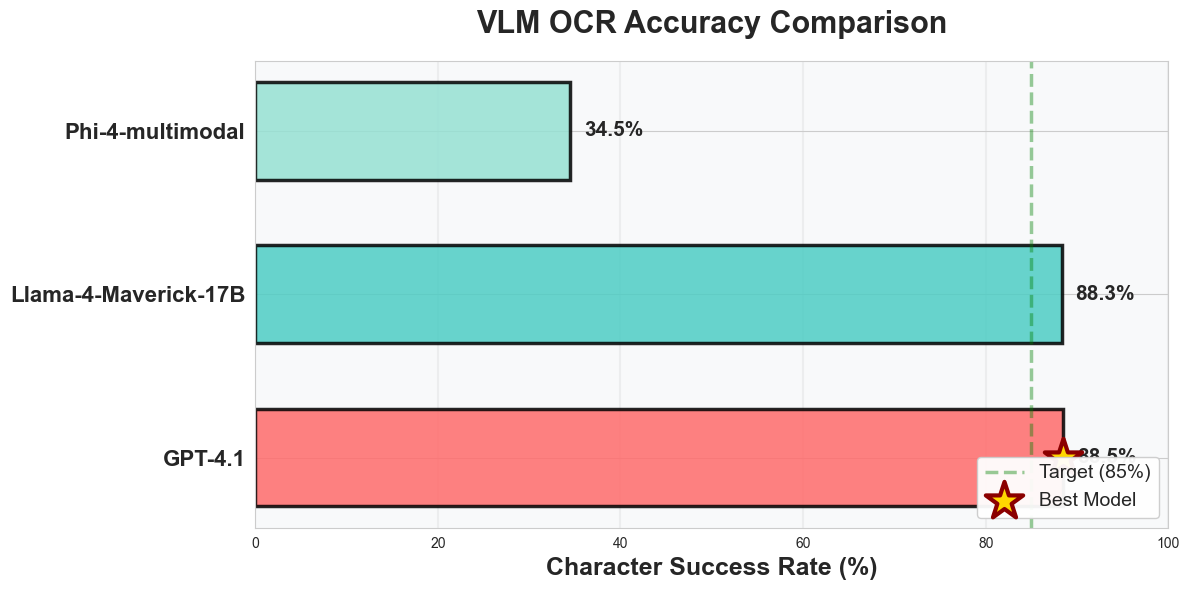

✅ Slide 1: Accuracy comparison saved


/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:81: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:82: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(output_dir / "slide_2_speed_vs_accuracy.png", dpi=300, bbox_inches="tight", facecolor='white')
/Users/ismatsamadov/SOCAR_Hackathon/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


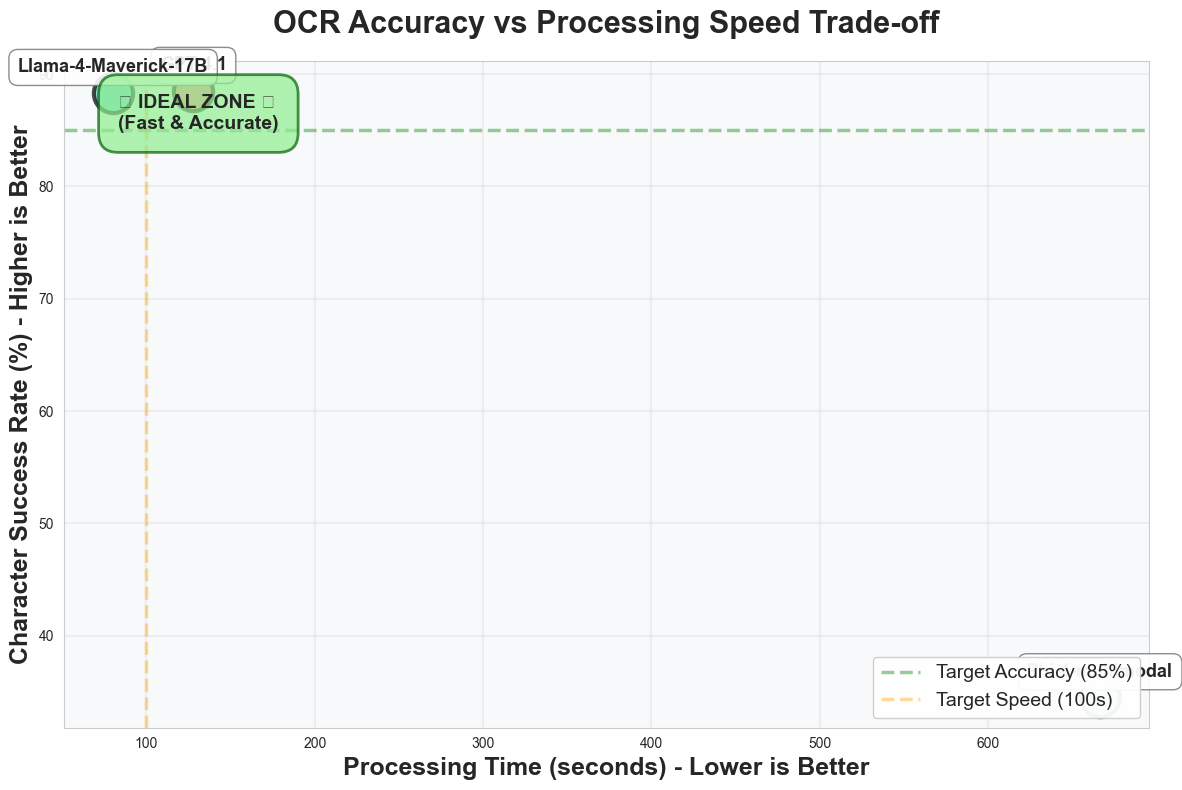

✅ Slide 2: Speed vs Accuracy saved


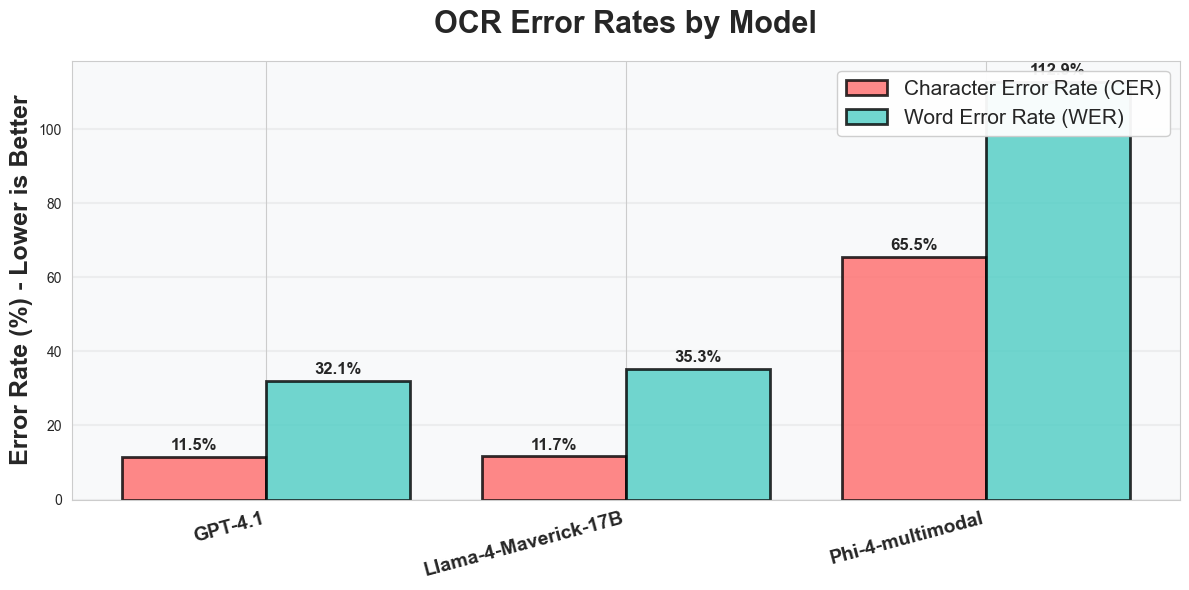

✅ Slide 3: Error rates saved


/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:184: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) Arial.
  plt.savefig(output_dir / "slide_4_summary_table.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:184: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.savefig(output_dir / "slide_4_summary_table.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:184: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) Arial.
  plt.savefig(output_dir / "slide_4_summary_table.png", dpi=300, bbox_inches="tight", facecolor='white')
/var/folders/z1/flq7k54d16b8vj_fzhts2p9r0000gn/T/ipykernel_32811/401424505.py:184: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) Arial.
  plt.savefig(output_dir / "slide_4_summar

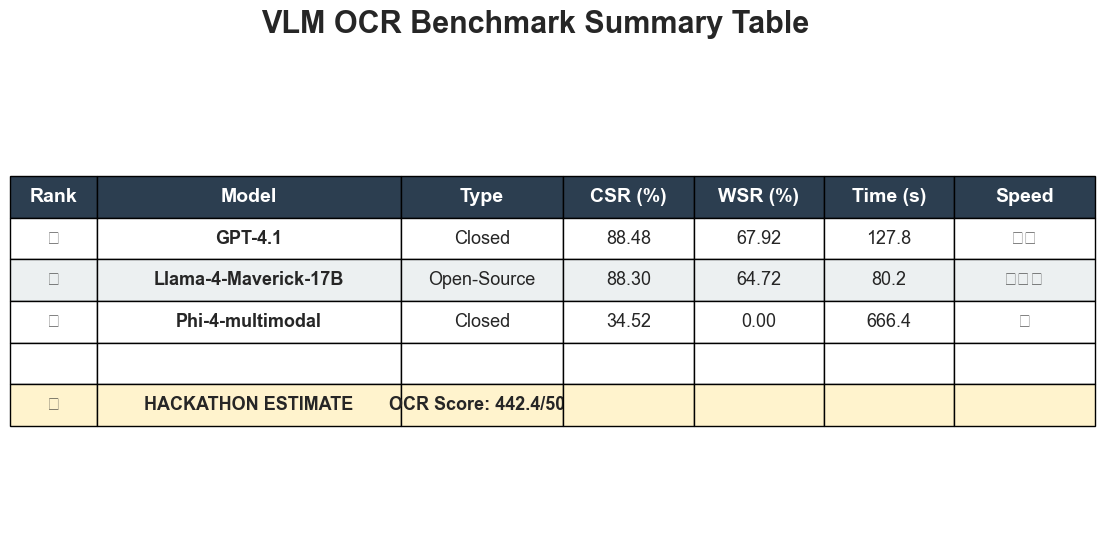

✅ Slide 4: Summary table saved


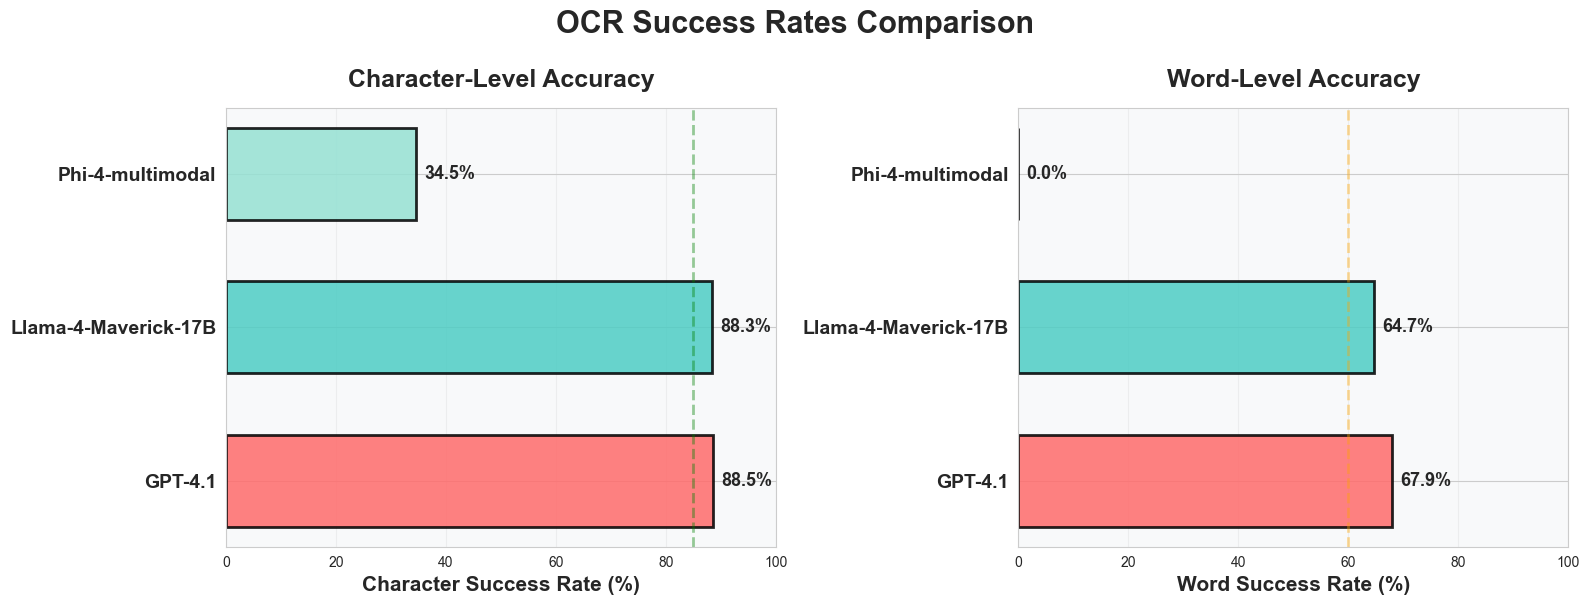

✅ Slide 5: Success rates comparison saved

🎨 ALL PRESENTATION SLIDES GENERATED
📁 Location: /Users/ismatsamadov/SOCAR_Hackathon/output/vlm_ocr_benchmark/

Generated files:
  1. slide_1_accuracy.png - Main accuracy chart
  2. slide_2_speed_vs_accuracy.png - Trade-off analysis
  3. slide_3_error_rates.png - Error rate comparison
  4. slide_4_summary_table.png - Complete results table
  5. slide_5_success_rates.png - CSR vs WSR comparison
  6. results.png - Comprehensive dashboard (6-panel)
  7. results_presentation.png - Web-optimized dashboard

All charts are high-resolution (300 DPI) and ready for presentations!


In [87]:
# === CREATE INDIVIDUAL PRESENTATION SLIDES ===
# These are standalone charts perfect for PowerPoint/Google Slides

# Color palette
colors_map = {
    "GPT-4.1": "#FF6B6B",
    "Llama-4-Maverick-17B": "#4ECDC4",
    "Phi-4-multimodal": "#95E1D3",
}

# === SLIDE 1: Main Accuracy Chart (Clean, Large) ===
fig1, ax = plt.subplots(figsize=(12, 6))
model_colors = [colors_map.get(m, "#999999") for m in df["Model"]]
y_pos = range(len(df["Model"]))

bars = ax.barh(y_pos, df["CSR"], color=model_colors, alpha=0.85, edgecolor='black', linewidth=2.5, height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(df["Model"], fontsize=16, fontweight='bold')
ax.set_xlabel("Character Success Rate (%)", fontsize=18, fontweight='bold')
ax.set_title("VLM OCR Accuracy Comparison", fontsize=22, fontweight='bold', pad=20)
ax.set_xlim(0, 100)

# Add reference line
ax.axvline(x=85, color='green', linestyle='--', alpha=0.4, linewidth=2.5, label='Target (85%)')

# Add value labels with better positioning
for i, (model, csr) in enumerate(zip(df["Model"], df["CSR"])):
    ax.text(csr + 1.5, i, f"{csr:.1f}%", va="center", fontsize=15, fontweight='bold')

# Highlight best model
best_idx = df["CSR"].idxmax()
ax.scatter([df.loc[best_idx, "CSR"]], [best_idx], s=800, color='gold', marker='*', 
           edgecolor='darkred', linewidth=3, zorder=5, label='Best Model')

ax.legend(fontsize=14, loc='lower right', framealpha=0.95)
ax.grid(axis='x', alpha=0.25, linewidth=1.5)
ax.set_facecolor('#F8F9FA')
fig1.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig(output_dir / "slide_1_accuracy.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()
print("✅ Slide 1: Accuracy comparison saved")

# === SLIDE 2: Speed vs Accuracy Scatter ===
fig2, ax = plt.subplots(figsize=(12, 8))

for i, row in df.iterrows():
    color = colors_map.get(row["Model"], "#999999")
    # Larger markers for better visibility
    ax.scatter(row["Response_Time"], row["CSR"], s=800, color=color, alpha=0.7,
              edgecolor='black', linewidth=3, zorder=3)
    
    # Model name labels with background
    ax.annotate(row["Model"], (row["Response_Time"], row["CSR"]), 
               fontsize=13, fontweight='bold', ha='center', va='bottom',
               xytext=(0, 12), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.9))

ax.set_xlabel("Processing Time (seconds) - Lower is Better", fontsize=18, fontweight='bold')
ax.set_ylabel("Character Success Rate (%) - Higher is Better", fontsize=18, fontweight='bold')
ax.set_title("OCR Accuracy vs Processing Speed Trade-off", fontsize=22, fontweight='bold', pad=20)

# Reference lines
ax.axhline(y=85, color='green', linestyle='--', alpha=0.4, linewidth=2.5, label='Target Accuracy (85%)')
ax.axvline(x=100, color='orange', linestyle='--', alpha=0.4, linewidth=2.5, label='Target Speed (100s)')

# Ideal zone annotation
ideal_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
ideal_y = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
ax.text(ideal_x, ideal_y, "★ IDEAL ZONE ★\n(Fast & Accurate)", 
       fontsize=14, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=1', facecolor='lightgreen', edgecolor='darkgreen', 
                linewidth=2, alpha=0.7))

ax.legend(fontsize=14, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.25, linewidth=1.5)
ax.set_facecolor('#F8F9FA')
fig2.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig(output_dir / "slide_2_speed_vs_accuracy.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()
print("✅ Slide 2: Speed vs Accuracy saved")

# === SLIDE 3: Error Rate Comparison ===
fig3, ax = plt.subplots(figsize=(12, 6))
x = range(len(df["Model"]))
width = 0.4

bars1 = ax.bar([i - width/2 for i in x], df["CER"], width, label="Character Error Rate (CER)", 
              color="#FF6B6B", alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar([i + width/2 for i in x], df["WER"], width, label="Word Error Rate (WER)", 
              color="#4ECDC4", alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel("Error Rate (%) - Lower is Better", fontsize=18, fontweight='bold')
ax.set_title("OCR Error Rates by Model", fontsize=22, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], fontsize=14, fontweight='bold', rotation=15, ha='right')
ax.legend(fontsize=15, loc='upper right', framealpha=0.95)

# Add value labels on bars
for i, (cer, wer) in enumerate(zip(df["CER"], df["WER"])):
    ax.text(i - width/2, cer + 1, f"{cer:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.text(i + width/2, wer + 1, f"{wer:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.grid(axis='y', alpha=0.25, linewidth=1.5)
ax.set_facecolor('#F8F9FA')
fig3.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig(output_dir / "slide_3_error_rates.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()
print("✅ Slide 3: Error rates saved")

# === SLIDE 4: Model Comparison Table ===
fig4, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
table_data.append(["Rank", "Model", "Type", "CSR (%)", "WSR (%)", "Time (s)", "Speed"])

for i, row in df.iterrows():
    rank = ["🥇", "🥈", "🥉"][i] if i < 3 else f"{i+1}"
    model_type = "Open-Source" if row["Model"] == "Llama-4-Maverick-17B" else "Closed"
    speed_rating = "⚡⚡⚡" if row["Response_Time"] < 100 else "⚡⚡" if row["Response_Time"] < 200 else "⚡"
    
    table_data.append([
        rank,
        row["Model"],
        model_type,
        f"{row['CSR']:.2f}",
        f"{row['WSR']:.2f}",
        f"{row['Response_Time']:.1f}",
        speed_rating
    ])

# Add hackathon score estimate
best_csr = df["CSR"].max()
ocr_score = (best_csr / 100) * 500
table_data.append(["", "", "", "", "", "", ""])
table_data.append(["📊", "HACKATHON ESTIMATE", f"OCR Score: {ocr_score:.1f}/500", "", "", "", ""])

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.08, 0.28, 0.15, 0.12, 0.12, 0.12, 0.13])

table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 2.5)

# Style header row
for i in range(7):
    cell = table[(0, i)]
    cell.set_facecolor('#2C3E50')
    cell.set_text_props(weight='bold', color='white', fontsize=14)

# Style data rows with alternating colors
for i in range(1, len(table_data)-2):
    for j in range(7):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ECF0F1')
        else:
            cell.set_facecolor('white')
        cell.set_text_props(fontsize=13)
        
        # Bold model names
        if j == 1:
            cell.set_text_props(weight='bold', fontsize=13)

# Style summary row
for j in range(7):
    cell = table[(len(table_data)-1, j)]
    cell.set_facecolor('#FFF3CD')
    cell.set_text_props(weight='bold', fontsize=13)

# Add title
fig4.suptitle('VLM OCR Benchmark Summary Table', fontsize=22, fontweight='bold', y=0.98)
fig4.patch.set_facecolor('white')

plt.savefig(output_dir / "slide_4_summary_table.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()
print("✅ Slide 4: Summary table saved")

# === SLIDE 5: Success Rates Side-by-Side ===
fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Character Success Rate
model_colors = [colors_map.get(m, "#999999") for m in df["Model"]]
y_pos = range(len(df["Model"]))

bars1 = ax1.barh(y_pos, df["CSR"], color=model_colors, alpha=0.85, edgecolor='black', linewidth=2, height=0.6)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df["Model"], fontsize=14, fontweight='bold')
ax1.set_xlabel("Character Success Rate (%)", fontsize=15, fontweight='bold')
ax1.set_title("Character-Level Accuracy", fontsize=18, fontweight='bold', pad=15)
ax1.set_xlim(0, 100)
ax1.axvline(x=85, color='green', linestyle='--', alpha=0.4, linewidth=2)
ax1.grid(axis='x', alpha=0.25)
ax1.set_facecolor('#F8F9FA')

for i, csr in enumerate(df["CSR"]):
    ax1.text(csr + 1.5, i, f"{csr:.1f}%", va="center", fontsize=13, fontweight='bold')

# Word Success Rate
bars2 = ax2.barh(y_pos, df["WSR"], color=model_colors, alpha=0.85, edgecolor='black', linewidth=2, height=0.6)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(df["Model"], fontsize=14, fontweight='bold')
ax2.set_xlabel("Word Success Rate (%)", fontsize=15, fontweight='bold')
ax2.set_title("Word-Level Accuracy", fontsize=18, fontweight='bold', pad=15)
ax2.set_xlim(0, 100)
ax2.axvline(x=60, color='orange', linestyle='--', alpha=0.4, linewidth=2)
ax2.grid(axis='x', alpha=0.25)
ax2.set_facecolor('#F8F9FA')

for i, wsr in enumerate(df["WSR"]):
    ax2.text(wsr + 1.5, i, f"{wsr:.1f}%", va="center", fontsize=13, fontweight='bold')

fig5.suptitle('OCR Success Rates Comparison', fontsize=22, fontweight='bold', y=1.00)
fig5.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig(output_dir / "slide_5_success_rates.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()
print("✅ Slide 5: Success rates comparison saved")

print("\n" + "="*70)
print("🎨 ALL PRESENTATION SLIDES GENERATED")
print("="*70)
print(f"📁 Location: {output_dir}/")
print("\nGenerated files:")
print("  1. slide_1_accuracy.png - Main accuracy chart")
print("  2. slide_2_speed_vs_accuracy.png - Trade-off analysis")
print("  3. slide_3_error_rates.png - Error rate comparison")
print("  4. slide_4_summary_table.png - Complete results table")
print("  5. slide_5_success_rates.png - CSR vs WSR comparison")
print("  6. results.png - Comprehensive dashboard (6-panel)")
print("  7. results_presentation.png - Web-optimized dashboard")
print("\nAll charts are high-resolution (300 DPI) and ready for presentations!")
print("="*70)